In [1]:
import pandas as pd
import numpy as np
import googlemaps
from datetime import datetime
import acquire_r
from env import google_key, google_key1
from googlemaps import convert
import wrangle_zillow_r
import wrangle_zillow
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import gmaps
import gmaps.datasets
gmaps.configure(api_key=google_key1) # Fill in with your API key
%matplotlib inline
import zillow_fe
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import median_absolute_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LogisticGAM, LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import explore
import evaluate
import model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Read CSV file which was saved after data wrangling
zillow = pd.read_csv('zillow_fe.csv')
orig_rows = zillow.shape[0]
orig_cols = zillow.shape[1]
print (f'There are {orig_rows} rows and {orig_cols} columns in the zillow dataframe.')

There are 64747 rows and 48 columns in the zillow dataframe.


In [6]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64747 entries, 0 to 64746
Data columns (total 48 columns):
Unnamed: 0                        64747 non-null int64
bathroomcnt                       64747 non-null int64
bedroomcnt                        64747 non-null int64
finishedsquarefeet12              64747 non-null int64
garagecarcnt                      64747 non-null int64
garagetotalsqft                   64747 non-null int64
hashottuborspa                    64747 non-null int64
latitude                          64747 non-null float64
longitude                         64747 non-null float64
lotsizesquarefeet                 64747 non-null int64
poolcnt                           64747 non-null int64
poolsizesum                       64747 non-null int64
numberofstories                   64747 non-null int64
structuretaxvaluedollarcnt        64747 non-null int64
taxvaluedollarcnt                 64747 non-null int64
taxamount                         64747 non-null int64
taxdeli

In [7]:
zillow['living_area'] = zillow.lotsizesquarefeet/zillow.finishedsquarefeet12

In [8]:
# split data in train/test (80/20)
train, test = wrangle_zillow.split_my_data(zillow, 0.8)

In [9]:
train.shape, test.shape

((51797, 49), (12950, 49))

In [10]:
# Split the train into train and validate sets (80/20)
train, validate = wrangle_zillow.split_my_data(train, 0.8)

In [11]:
#check train and validate shapes
train.shape, validate.shape

((41437, 49), (10360, 49))

# Modeling

### Baseline


In [12]:
# Lets first establish a baseline

train["base_logerror"] = train.logerror.mean()

RMSE_base = sqrt(mean_squared_error(train.logerror,train.base_logerror))

print(f'The Baseline train RMSE logerror is :{RMSE_base}')

The Baseline train RMSE logerror is :0.16339650601805303


In [13]:
validate["base_logerror"] = validate.logerror.mean()
RMSE_validate = sqrt(mean_squared_error(validate.logerror,validate.base_logerror))
R2_validate = r2_score(validate.logerror,validate.base_logerror)
print(f'The baseline test RMSE =  {RMSE_validate} , R2 = {R2_validate}')

The baseline test RMSE =  0.17107394558243763 , R2 = 0.0


In [14]:
#Baseline for test dataset
test["base_logerror"] = test.logerror.mean()
RMSE_test = sqrt(mean_squared_error(test.logerror,test.base_logerror))
R2_test = r2_score(test.logerror,test.base_logerror)
print(f'The baseline test RMSE =  {RMSE_test} , R2 = {R2_test}')


The baseline test RMSE =  0.15607026290260517 , R2 = 0.0


***

### Polynomial Regression Method


In [15]:
#polynomial model on train data
features = ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'taxvaluedollarcnt', 'median_income', 'living_area']
RMSE, R2, y_train, lm_poly, poly = model.poly_regression(train, features,3)
print(f' The RMSE is : {RMSE} and R2 is {R2}')
lm_poly

 The RMSE is : 0.163 and R2 is 0.006


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
RMSE, R2, y_test = model.poly_regression_1(validate, lm_poly,poly, features)
print(f' The RMSE is : {RMSE} and R2 is {R2}')

 The RMSE is : 0.171 and R2 is -0.001


In [17]:
RMSE, R2, y_test = model.poly_regression_1(test, lm_poly,poly, features)
print(f' The RMSE is : {RMSE} and R2 is {R2}')

 The RMSE is : 0.156 and R2 is 0.002


***

### Simple Linear Regression Method

In [18]:
features = ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'taxvaluedollarcnt', 'median_income', 'living_area']
RMSE, R2, lm, y_train = model.linear_reg(train, features)
print(f' The RMSE is : {RMSE} and R2 is {R2}')

 The RMSE is : 0.163 and R2 is 0.002


In [19]:
RMSE, R2, y_train = model.linear_reg1(validate, features, lm)
print(f' The RMSE is : {RMSE} and R2 is {R2}')

 The RMSE is : 0.171 and R2 is 0.001


***

### GAM Model

In [20]:
features = ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'taxvaluedollarcnt', 'median_income', 'living_area']

RMSE, R2, gam = model.GAM_model(train, features)
print(f' The RMSE is : {RMSE} and R2 is {R2}')

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


 The RMSE is : 0.163 and R2 is 0.004


In [21]:
RMSE, R2 = model.GAM_model1(validate, features, gam)
print(f' The RMSE is : {RMSE} and R2 is {R2}')

 The RMSE is : 0.171 and R2 is 0.003


***
### Run all functions together with a single function

In [20]:
features = ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'taxvaluedollarcnt', 'median_income', 'living_area']

summary_results_train, lm_poly, poly, lm, gam = model.run_all_functions_train(train,features)
summary_results_train

100% (11 of 11) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


,RMSE,R2
Baseline,0.163,0.000
Linear_model,0.163,0.002
polynomial_LR,0.161,0.032
GAM,0.163,0.004


In [21]:
summary_results_validate = model.run_all_functions_test(validate,train,features)
summary_results_validate

100% (11 of 11) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


,RMSE,R2
Baseline,0.171,0.000
Linear_model,0.171,0.001
polynomial_LR,0.262,-1.345
GAM,0.171,0.003


### Seems like polynomial linear regression model performed best. Lets run the test dataset on polynomial LR model

In [22]:
features = ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'taxvaluedollarcnt', 'median_income', 'living_area']
RMSE, R2, y_test = model.linear_reg1(test, features,lm)
print(f' The baseline test  RMSE is : {RMSE_test} and R2 is {R2_test}')
print(f' The model RMSE is : {RMSE} and R2 is {R2}')

 The baseline test  RMSE is : 0.15607026290260517 and R2 is 0.0
 The model RMSE is : 0.156 and R2 is 0.0


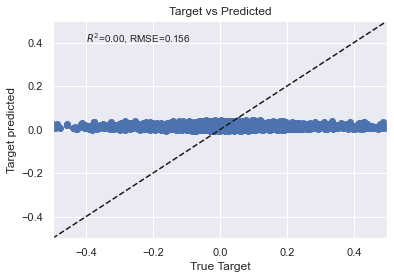

<Figure size 864x576 with 0 Axes>

In [23]:
model.plot_scatter(y_test['logerror'], y_test['predicted'])

***

### Now we will regression model based on clusters we made based with finished square feet feature

(-3.0, 3.0)

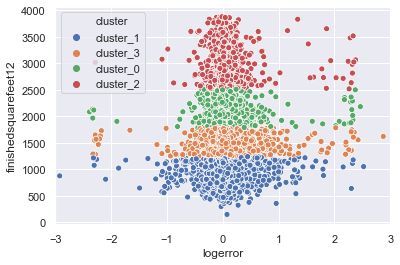

In [24]:
# Create 4 clusters based on finished square feet
X = train[['finishedsquarefeet12']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 4)
sns.scatterplot(x = 'logerror', y = 'finishedsquarefeet12',data = train, hue = 'cluster')
plt.xlim(-3,3)

In [25]:
#features tobe used on polynomal model 
features = ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'taxvaluedollarcnt', 'median_income', 'living_area']

In [26]:
# This function will take a dataset and run polynomial model on each clusters. The predicted values from
# each cluster is concatanated and then overall RMSE and R2 is calculated.
# Running this on train dataset
df1, y_train_comb, lm0, lm1, lm1, lm3  = model.cluster_lm_model(train, features)
df1

,RMSE,R2
cluster_0,0.155,0.001
cluster_1,0.161,0.003
cluster_2,0.192,0.001
cluster_3,0.162,0.001
overall,0.163,0.003


In [27]:
print(f'The baseline train RMSE: {RMSE_base}')

The baseline train RMSE: 0.16339650601805303


#### Lets run this on validate data set

In [28]:
validate = model.clusters(validate,kmeans)
test = model.clusters(test,kmeans)

In [29]:
validate_summary, y_validate_comb  = model.cluster_lm_test(validate, features, lm0, lm1, lm1, lm3)
validate_summary

,RMSE,R2
cluster_0,0.198,0.001
cluster_1,0.165,-0.006
cluster_2,0.202,-0.003
cluster_3,0.155,-0.002
overall,0.171,-0.002


In [30]:
# The Baseline for validate data is:
print(f'The baseline validate RMSE: {RMSE_validate}')

The baseline validate RMSE: 0.17107394558243763


#### Lets run this on test data set


In [31]:
test_summary, y_test_comb  = model.cluster_lm_test(test, features, lm0, lm1, lm1, lm3)
test_summary

,RMSE,R2
cluster_0,0.132,-0.003
cluster_1,0.168,-0.007
cluster_2,0.204,-0.001
cluster_3,0.141,0.001
overall,0.156,-0.003


In [32]:
# The Baseline for validate data is:
print(f'The baseline test RMSE: {RMSE_test}')

The baseline test RMSE: 0.15607026290260517


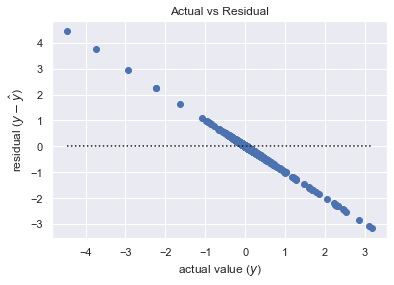

In [33]:
evaluate.plot_residuals(y_train.logerror, y_train.predicted, y_train)

### Conclusions:
#### 1. Zestimate is really good!!
#### 2. Linear regression model worked best, but the it did no